In [1]:
!pip install pyscf

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 51.2/51.2 MB 29.1 MB/s eta 0:00:00:00:0100:01


In [2]:
!pip install pyberny

In [3]:
%pip install -U qiskit-ibm-runtime
%pip install -U qiskit-nature
%pip install -U qiskit-algorithms
%pip install -U qiskit-addon-sqd
%pip install -U ffsim

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 17.9 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 366.8/366.8 kB 19.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.4/7.4 MB 80.5 MB/s eta 0:00:00:00:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 75.8/75.8 kB 3.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 130.2/130.2 kB 7.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 56.6 MB/s eta 0:00:00:00:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.5/49.5 kB 2.6 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 23.5 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 327.8/327.8 kB 15.5 MB/s eta 0:00:00
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated pac

In [4]:
%pip install qiskit==1.4.2

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 6.8/6.8 MB 47.4 MB/s eta 0:00:0000:0100:01
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 49.7/49.7 MB 30.5 MB/s eta 0:00:00:00:0100:01
  Attempting uninstall: qiskit
    Found existing installation: qiskit 2.1.2
    Uninstalling qiskit-2.1.2:
      Successfully uninstalled qiskit-2.1.2
Note: you may need to restart the kernel to use updated packages.


In [5]:
import qiskit
# Import common packages first
import numpy as np
from math import comb
import warnings
import pyscf
import matplotlib.pyplot as plt
import pickle
from functools import partial
from qiskit_nature.units import DistanceUnit
from qiskit_nature.second_q.drivers import PySCFDriver
from qiskit_nature.second_q.circuit.library import HartreeFock
from qiskit_nature.second_q.circuit.library import UCCSD
from qiskit_nature.second_q.mappers import JordanWignerMapper
from qiskit_nature.second_q.algorithms import GroundStateEigensolver
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_algorithms import VQE
from qiskit_algorithms.optimizers import SLSQP
from qiskit.primitives import Estimator
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_nature.second_q.drivers import GaussianForcesDriver
from qiskit_nature.second_q.mappers import DirectMapper
from qiskit_nature.second_q.problems import HarmonicBasis

# Potential Energy Using DMET + FCI

In [6]:
"""
one_shot_dmet_fixed.py

One-shot DMET toy driver — robust AO selection, bath truncation/capping,
iterative bath reduction, and CASCI fallback when FCI is infeasible.

Dependencies:
  pip install pyscf numpy scipy
"""

import numpy as np
from pyscf import gto, scf, ao2mo, fci, mcscf
from scipy.linalg import svd

def one_shot_dmet(mol_geom: str,
                  frag_atoms,
                  basis='sto-3g',
                  charge=0,
                  spin=0,
                  max_fci_orbitals=14,
                  max_bath_cap=8,
                  verbose=True):
    """
    Run a single-shot DMET impurity solve with several robustness measures.

    Parameters
    ----------
    mol_geom : str
        PySCF-style geometry block (XYZ-like multiline string).
    frag_atoms : list[int]
        Atom indices (0-based) forming the fragment.
    basis : str
        Basis set (default 'sto-3g' recommended for debugging; use cc-pVDZ for production).
    max_fci_orbitals : int
        Maximum number of impurity orbitals allowed for attempting full FCI.
    max_bath_cap : int
        Hard cap on bath orbitals (helps control nimp).
    verbose : bool
        Print diagnostics.

    Returns
    -------
    dict
        Result dictionary with energies, impurity size, solver used, etc.
    """

    # Build molecule and SCF
    mol = gto.Mole()
    mol.atom = mol_geom
    mol.basis = basis
    mol.charge = charge
    mol.spin = spin
    mol.verbose = 0
    mol.build()

    mf = scf.RHF(mol)
    mf.conv_tol = 1e-9
    mf.kernel()

    mo_coeff = mf.mo_coeff
    mo_occ = mf.mo_occ
    nocc = int(np.sum(mo_occ > 0))
    nao = mo_coeff.shape[0]

    # Robust AO selection: use aoslice_by_atom()
    aoslices = mol.aoslice_by_atom()
    frag_ao_indices = []
    for ia in frag_atoms:
        if ia < 0 or ia >= mol.natm:
            raise IndexError(f"Fragment atom index {ia} out of range (0..{mol.natm-1})")
        b0,b1,p0,p1 = aoslices[ia]
        frag_ao_indices.extend(range(p0,p1))
    frag_ao_indices = sorted(set(frag_ao_indices))
    if len(frag_ao_indices) == 0:
        raise RuntimeError("No AOs found for fragment atoms; check atom indices and basis.")

    # Helper function: build impurity AO->imp basis given nbath
    def build_impurity(nbath):
        occ_mo = mo_coeff[:, :nocc]
        P_frag = np.zeros((nao, len(frag_ao_indices)))
        for j, ao_idx in enumerate(frag_ao_indices):
            P_frag[ao_idx, j] = 1.0
        X = P_frag.T @ occ_mo  # (nfragAO x nocc)
        U, svals, Vh = svd(X, full_matrices=False)
        nbath_eff = min(nbath, Vh.shape[0], nocc)
        if nbath_eff <= 0:
            nbath_eff = 1
        bath_mos = occ_mo @ Vh.T[:, :nbath_eff]  # nao x nbath_eff

        frag_aos = np.zeros((nao, len(frag_ao_indices)))
        for j, ao_idx in enumerate(frag_ao_indices):
            frag_aos[ao_idx, j] = 1.0

        impurity_basis_ao = np.hstack([frag_aos, bath_mos])  # nao x (nfrag + nbath)
        S = mol.intor('int1e_ovlp')
        M = impurity_basis_ao.T @ S @ impurity_basis_ao
        eigvals, eigvecs = np.linalg.eigh(M)
        keep = eigvals > 1e-10
        if not np.any(keep):
            raise RuntimeError("Impurity overlap matrix singular.")
        Tmat = eigvecs[:, keep] @ np.diag(1.0/np.sqrt(eigvals[keep]))
        C_imp_ao = impurity_basis_ao @ Tmat   # nao x nimp
        nimp = C_imp_ao.shape[1]
        return C_imp_ao, nbath_eff, nimp, svals

    # Start with a reasonable nbath
    nbath_try = min(len(frag_ao_indices), nocc, max_bath_cap)
    C_imp_ao, nbath_eff, nimp, svals = build_impurity(nbath_try)
    if verbose:
        print(f"Initial fragment AOs = {len(frag_ao_indices)}, nbath = {nbath_eff}, nimp = {nimp}")

    # Iteratively reduce nbath until nimp <= max_fci_orbitals (or nbath==1)
    while nimp > max_fci_orbitals and nbath_try > 1:
        nbath_try -= 1
        C_imp_ao, nbath_eff, nimp, svals = build_impurity(nbath_try)
        if verbose:
            print(f"Reduced nbath -> {nbath_try}: nimp = {nimp}")

    # If still too large, increase singular-value threshold (drop very small singulars)
    if nimp > max_fci_orbitals:
        occ_mo = mo_coeff[:, :nocc]
        P_frag = np.zeros((nao, len(frag_ao_indices)))
        for j, ao_idx in enumerate(frag_ao_indices):
            P_frag[ao_idx, j] = 1.0
        X = P_frag.T @ occ_mo
        U, svals_full, Vh_full = svd(X, full_matrices=False)
        tol = 1e-6
        while nimp > max_fci_orbitals and tol < 1e-1:
            nbath_try = int(np.sum(svals_full > tol))
            nbath_try = min(max(1, nbath_try), max_bath_cap, nocc)
            C_imp_ao, nbath_eff, nimp, svals = build_impurity(nbath_try)
            if verbose:
                print(f"Tolerance {tol:.1e} => nbath {nbath_try}, nimp {nimp}")
            tol *= 10.0

    # Last resort: auto-reduce fragment by dropping last atom(s)
    frag_atoms_current = list(frag_atoms)
    while nimp > max_fci_orbitals and len(frag_atoms_current) > 1:
        dropped = frag_atoms_current.pop()  # drop last atom
        if verbose:
            print(f"Auto-dropping fragment atom {dropped} to reduce impurity")
        frag_ao_indices = []
        for ia in frag_atoms_current:
            b0,b1,p0,p1 = aoslices[ia]
            frag_ao_indices.extend(range(p0,p1))
        frag_ao_indices = sorted(set(frag_ao_indices))
        nbath_try = min(len(frag_ao_indices), nocc, max_bath_cap)
        C_imp_ao, nbath_eff, nimp, svals = build_impurity(nbath_try)
        if verbose:
            print(f"After dropping: fragment AOs {len(frag_ao_indices)}, nbath {nbath_eff}, nimp {nimp}")

    if nimp > max_fci_orbitals and verbose:
        print("Warning: could not reduce nimp below max_fci_orbitals. Will try CASCI fallback.")

    # Build impurity integrals
    hcore_ao = mf.get_hcore()
    h_imp = C_imp_ao.T @ hcore_ao @ C_imp_ao
    eri_ao = mol.intor('int2e')
    eri_imp = ao2mo.incore.general(eri_ao, (C_imp_ao, C_imp_ao, C_imp_ao, C_imp_ao), compact=False)
    eri_imp = eri_imp.reshape((nimp, nimp, nimp, nimp))

    # Electrons on impurity (rounded)
    dm = mf.make_rdm1()
    n_elec_imp = np.trace(C_imp_ao.T @ dm @ C_imp_ao)
    nelec_imp_int = int(round(n_elec_imp))
    if nelec_imp_int % 2 == 0:
        neleca = nelecb = nelec_imp_int // 2
    else:
        neleca = (nelec_imp_int + 1)//2
        nelecb = nelec_imp_int - neleca

    if verbose:
        print("Final fragment AOs:", len(frag_ao_indices))
        print("Number of bath orbitals used:", nbath_eff)
        print("Impurity dimension (nimp):", nimp)
        print("Impurity electron guess (rounded):", nelec_imp_int, "(alpha,beta) =", (neleca, nelecb))

    # Solve impurity: FCI if small enough else CASCI fallback
    E_imp_corr = None
    solver_used = None
    h1 = h_imp
    eri = eri_imp

    if nimp <= max_fci_orbitals:
        try:
            e_fci, ci_vector = fci.direct_spin1.kernel(h1, eri, nimp, (neleca, nelecb), ecore=0.0, verbose=4)
            E_imp_corr = e_fci
            solver_used = 'FCI'
            if verbose:
                print("FCI (impurity) energy (Ha) = {:.12f}".format(e_fci))
        except Exception as e:
            if verbose:
                print("FCI failed:", e)
            E_imp_corr = None

    if E_imp_corr is None:
        # CASCI fallback
        ncas = min(12, max(4, nimp//2))
        nelecas = min(max(2, nelec_imp_int), 2*ncas)
        if nelecas % 2 == 1:
            nelecas -= 1
        if nelecas < 0:
            nelecas = 0
        if verbose:
            print("Using CASCI fallback: ncas =", ncas, ", nelecas =", nelecas)
        try:
            mc = mcscf.CASCI(mf, ncas, nelecas)
            mo0 = C_imp_ao.copy()
            # pad mo0 to have at least same number of columns as mf.mo_coeff
            if mo0.shape[1] < mf.mo_coeff.shape[1]:
                pad_cols = mf.mo_coeff.shape[1] - mo0.shape[1]
                mo0 = np.hstack([mo0, mf.mo_coeff[:, :pad_cols]])
            mc.mo_coeff = mo0
            mc.fcisolver = fci
            e_cas, civec = mc.kernel()
            E_imp_corr = e_cas
            solver_used = 'CASCI'
            if verbose:
                print("CASCI (impurity) energy (Ha) = {:.12f}".format(e_cas))
        except Exception as e:
            raise RuntimeError(f"Both FCI and CASCI impurity solves failed: {e}")

    # Rough DMET energy estimate:
    E_mf = mf.e_tot
    occ_mo = mo_coeff[:, :nocc]
    dm_imp_mf = C_imp_ao.T @ (occ_mo @ occ_mo.T) @ C_imp_ao
    E_imp_mf = np.einsum('ij,ji', h1, dm_imp_mf) + 0.5 * np.einsum('ijkl,li,kj', eri, dm_imp_mf, dm_imp_mf)
    E_env = E_mf - E_imp_mf
    E_total_dmet_approx = E_env + E_imp_corr

    if verbose:
        print("Mean-field total energy (RHF) = {:.12f} Ha".format(E_mf))
        print(f"One-shot DMET approx total energy ({solver_used}) = {E_total_dmet_approx:.12f} Ha")

    return {
        'mol': mol, 'mf': mf,
        'frag_atoms_initial': frag_atoms,
        'frag_ao_indices': frag_ao_indices,
        'nbath': nbath_eff,
        'nimp': nimp,
        'nelec_imp': nelec_imp_int,
        'solver_used': solver_used,
        'E_imp_corr': E_imp_corr,
        'E_total_dmet_approx': E_total_dmet_approx
    }

co2_geom = """
 C    0.000000    0.000000    0.000000
 O    0.000000    0.000000    1.162000
 O    0.000000    0.000000   -1.162000
"""
res = one_shot_dmet(co2_geom, frag_atoms=[0,1], basis='sto-3g', max_fci_orbitals=14, max_bath_cap=6)
print(res)

Initial fragment AOs = 10, nbath = 6, nimp = 15
Reduced nbath -> 5: nimp = 15
Reduced nbath -> 4: nimp = 14
Final fragment AOs: 10
Number of bath orbitals used: 4
Impurity dimension (nimp): 14
Impurity electron guess (rounded): 23 (alpha,beta) = (12, 11)
FCI (impurity) energy (Ha) = -242.179266181174
Mean-field total energy (RHF) = -185.065220119893 Ha
One-shot DMET approx total energy (FCI) = -247.335229808833 Ha
{'mol': <pyscf.gto.mole.Mole object at 0x7e2792683e10>, 'mf': <pyscf.scf.hf.RHF object at 0x7e279f516710>, 'frag_atoms_initial': [0, 1], 'frag_ao_indices': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'nbath': 4, 'nimp': 14, 'nelec_imp': 23, 'solver_used': 'FCI', 'E_imp_corr': -242.17926618117406, 'E_total_dmet_approx': -247.33522980883305}


In [7]:
nh3_geom = """
N    0.000000    0.000000    0.111100
H    0.000000    0.931600   -0.259200
H    0.806800   -0.465800   -0.259200
H   -0.806800   -0.465800   -0.259200
"""
res = one_shot_dmet(nh3_geom, frag_atoms=[0,1], basis='sto-3g', max_fci_orbitals=14, max_bath_cap=6)
print(res)

Initial fragment AOs = 6, nbath = 5, nimp = 8
Final fragment AOs: 6
Number of bath orbitals used: 5
Impurity dimension (nimp): 8
Impurity electron guess (rounded): 9 (alpha,beta) = (5, 4)
FCI (impurity) energy (Ha) = -67.296207182553
Mean-field total energy (RHF) = -55.452656851781 Ha
One-shot DMET approx total energy (FCI) = -80.474005280125 Ha
{'mol': <pyscf.gto.mole.Mole object at 0x7e279269cb10>, 'mf': <pyscf.scf.hf.RHF object at 0x7e2793ac7850>, 'frag_atoms_initial': [0, 1], 'frag_ao_indices': [0, 1, 2, 3, 4, 5], 'nbath': 5, 'nimp': 8, 'nelec_imp': 9, 'solver_used': 'FCI', 'E_imp_corr': -67.29620718255318, 'E_total_dmet_approx': -80.47400528012517}


In [8]:
nh2cooh_geom = """
C   0.00000000   0.00000000   0.00000000
O   1.20500000   0.00000000   0.00000000
O  -0.74624274   1.12787745   0.00000000
H  -0.11545599   1.85274770   0.00000000
N  -0.78998866  -1.09373606   0.00000000
H  -1.18505755  -0.17595546   0.00000000
H   0.20010645  -1.22531534   0.00000000
"""
res = one_shot_dmet(nh2cooh_geom, frag_atoms=[0,1], basis='sto-3g', max_fci_orbitals=14, max_bath_cap=6)
print(res)

Initial fragment AOs = 10, nbath = 6, nimp = 16
Reduced nbath -> 5: nimp = 15
Reduced nbath -> 4: nimp = 14
Final fragment AOs: 10
Number of bath orbitals used: 4
Impurity dimension (nimp): 14
Impurity electron guess (rounded): 21 (alpha,beta) = (11, 10)
FCI (impurity) energy (Ha) = -260.008229601144
Mean-field total energy (RHF) = -240.180227879533 Ha
One-shot DMET approx total energy (FCI) = -329.648130624267 Ha
{'mol': <pyscf.gto.mole.Mole object at 0x7e2792683e10>, 'mf': <pyscf.scf.hf.RHF object at 0x7e278fa57d90>, 'frag_atoms_initial': [0, 1], 'frag_ao_indices': [0, 1, 2, 3, 4, 5, 6, 7, 8, 9], 'nbath': 4, 'nimp': 14, 'nelec_imp': 21, 'solver_used': 'FCI', 'E_imp_corr': -260.0082296011442, 'E_total_dmet_approx': -329.64813062426686}


# Potential Energy using NumPy Minimum Eigen Solver

In [9]:
from qiskit_algorithms import NumPyMinimumEigensolver
from qiskit_nature.second_q.transformers import ActiveSpaceTransformer
import matplotlib.pyplot as plt
def modelMolec(atomGeo, use_vqe=False):
    driver = PySCFDriver(
        atom=atomGeo,
        basis="sto3g",
        charge=0,
        spin=0,
        unit=DistanceUnit.ANGSTROM,
    )

    es_problem = driver.run()

    transformer2 = ActiveSpaceTransformer(num_electrons=4, num_spatial_orbitals=4)
    es_problem = transformer2.transform(es_problem)

    mapper = JordanWignerMapper()

    solver = NumPyMinimumEigensolver() if not use_vqe else VQE(
        Estimator(),
        UCCSD(
            es_problem.num_spatial_orbitals,
            es_problem.num_particles,
            mapper,
            initial_state=HartreeFock(
                es_problem.num_spatial_orbitals,
                es_problem.num_particles,
                mapper,
            ),
        ),
        SLSQP()
    )

    calc = GroundStateEigensolver(mapper, solver)
    res = calc.solve(es_problem)
    return res
co2_geom = """
 C    0.000000    0.000000    0.000000
 O    0.000000    0.000000    1.162000
 O    0.000000    0.000000   -1.162000
"""
co2_eneg = modelMolec(
    "C    0.000000    0.000000    0.000000; "
    "O    0.000000    0.000000    1.162000; "
    "O    0.000000    0.000000   -1.162000; "
)
print(f"CO2 Energy: {co2_eneg}")

CO2 Energy: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -243.429141950042
  - computed part:      -4.719757993728
  - ActiveSpaceTransformer extracted energy part: -238.709383956314
~ Nuclear repulsion energy (Hartree): 58.291465574664
> Total ground state energy (Hartree): -185.137676375378
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 4.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  0.0]
 
  0: 
  * Electronic dipole moment (a.u.): [0.0  0.0  0.0]
    - computed part:      [0.0  0.0  0.0]
    - ActiveSpaceTransformer extracted energy part: [0.0  0.0  0.0]
  > Dipole moment (a.u.): [0.0  0.0  0.0]  Total: 0.0
                 (debye): [0.0  0.0  0.0]  Total: 0.0
 


In [10]:
nh3_geom = """
N    0.000000    0.000000    0.111100
H    0.000000    0.931600   -0.259200
H    0.806800   -0.465800   -0.259200
H   -0.806800   -0.465800   -0.259200
"""
nh3_eneg = modelMolec(
    "N    0.000000    0.000000    0.111100; "
    "H    0.000000    0.931600   -0.259200; "
    "H    0.806800   -0.465800   -0.259200; "
    "H   -0.806800   -0.465800   -0.259200; "
    
)
print(f"NH3 Energy: {nh3_eneg}")

NH3 Energy: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -67.526101382989
  - computed part:      -5.350425032998
  - ActiveSpaceTransformer extracted energy part: -62.175676349991
~ Nuclear repulsion energy (Hartree): 12.068827248365
> Total ground state energy (Hartree): -55.457274134624
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 4.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [0.0  0.0  0.00018897]
 
  0: 
  * Electronic dipole moment (a.u.): [-0.000000000049  -0.009299098795  0.692408940743]
    - computed part:      [0.0  0.798639585179  0.859314783555]
    - ActiveSpaceTransformer extracted energy part: [-0.000000000049  -0.807938683975  -0.166905842812]
  > Dipole moment (a.u.): [0.000000000049  0.009299098795  -0.692219970743]  Total: 0.692282428734
                 (debye): [0.000000000124  0.023635949315  -1.759447501696]  Total: 1.759606254059
 


In [11]:
nh2cooh_geom = """
C   0.00000000   0.00000000   0.00000000
O   1.20500000   0.00000000   0.00000000
O  -0.74624274   1.12787745   0.00000000
H  -0.11545599   1.85274770   0.00000000
N  -0.78998866  -1.09373606   0.00000000
H  -1.18505755  -0.17595546   0.00000000
H   0.20010645  -1.22531534   0.00000000
"""
nh2cooh_eneg = modelMolec(
    "C   0.00000000   0.00000000   0.00000000; "
    "O   1.20500000   0.00000000   0.00000000; "
    "O  -0.74624274   1.12787745   0.00000000; "
    "H  -0.11545599   1.85274770   0.00000000; "
    "N  -0.78998866  -1.09373606   0.00000000; "
    "H  -1.18505755  -0.17595546   0.00000000; "
    "H   0.20010645  -1.22531534   0.00000000; "
)
print(f"NH2COOH Energy: {nh2cooh_eneg}")

NH2COOH Energy: === GROUND STATE ENERGY ===
 
* Electronic ground state energy (Hartree): -369.639679428588
  - computed part:      -4.139599003408
  - ActiveSpaceTransformer extracted energy part: -365.500080425181
~ Nuclear repulsion energy (Hartree): 129.438893116141
> Total ground state energy (Hartree): -240.200786312447
 
=== MEASURED OBSERVABLES ===
 
  0:  # Particles: 4.000 S: 0.000 S^2: 0.000 M: 0.000
 
=== DIPOLE MOMENTS ===
 
~ Nuclear dipole moment (a.u.): [-5.59409886  3.43617231  0.0]
 
  0: 
  * Electronic dipole moment (a.u.): [-5.526380125099  2.691518817392  0.0]
    - computed part:      [2.165334991046  -2.808063202858  0.0]
    - ActiveSpaceTransformer extracted energy part: [-7.691715116146  5.49958202025  0.0]
  > Dipole moment (a.u.): [-0.067718734901  0.744653492608  0.0]  Total: 0.747726320996
                 (debye): [-0.172123839205  1.892720208279  0.0]  Total: 1.900530558253
 


# Vibrational Energy in Ground State

In [12]:
import numpy as np
from pyscf import gto, dft
from pyscf.hessian.rks import Hessian  # correct import for DFT Hessian
from pyscf.hessian import thermo

# Build molecule
mol = gto.Mole()
mol.atom = """
 C    0.000000    0.000000    0.000000
 O    0.000000    0.000000    1.162000
 O    0.000000    0.000000   -1.162000
"""
mol.basis = "cc-pVDZ"
mol.unit = "Angstrom"
mol.build()

# DFT SCF calculation
mf = dft.RKS(mol)
mf.xc = "B3LYP"  # note: newer PySCF uses VWN-RPA; warning will appear
mf.kernel()

# Analytic Hessian (DFT)
h4 = Hessian(mf).kernel()

# Harmonic vibrational analysis
results = thermo.harmonic_analysis(mol, h4, exclude_trans=True, exclude_rot=True)

# Extract frequencies
freqs = np.array(results["freq_wavenumber"])
print("All frequencies (cm^-1):", freqs)

real_parts = np.real(freqs)
imag_parts = np.imag(freqs)
print("Real parts:", real_parts)
print("Imag parts:", imag_parts)

# Filter physical modes
imag_tol = 1e-3
tiny_tol = 1e-2
physical = (real_parts > tiny_tol) & (np.abs(imag_parts) <= imag_tol)
vib_freqs = real_parts[physical]

sig_imag = np.where(np.abs(imag_parts) > imag_tol)[0]
if sig_imag.size:
    print(f"Warning: significant imaginary mode(s) at indices {sig_imag}")

# Zero-point energy calculation
cm_to_hartree = 4.556335e-6
zpe_cm1 = 0.5 * np.sum(vib_freqs)
zpe_hartree = zpe_cm1 * cm_to_hartree
zpe_kjmol = zpe_hartree * 2625.50

print("Vibrational frequencies used (cm^-1):", np.sort(vib_freqs))
print(f"ZPE: {zpe_cm1:.2f} cm^-1 = {zpe_hartree:.6f} Hartree = {zpe_kjmol:.2f} kJ/mol")

/usr/local/lib/python3.11/dist-packages/pyscf/dft/libxc.py:511: UserWarning: Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, corresponding to the original definition by Stephens et al. (issue 1480) and the same as the B3LYP functional in Gaussian. To restore the VWN5 definition, you can put the setting "B3LYP_WITH_VWN5 = True" in pyscf_conf.py
  warnings.warn('Since PySCF-2.3, B3LYP (and B3P86) are changed to the VWN-RPA variant, '


converged SCF energy = -188.598348185277
All frequencies (cm^-1): [ 638.40288709  638.40288709 1388.35139091 2469.97202037]
Real parts: [ 638.40288709  638.40288709 1388.35139091 2469.97202037]
Imag parts: [0. 0. 0. 0.]
Vibrational frequencies used (cm^-1): [ 638.40288709  638.40288709 1388.35139091 2469.97202037]
ZPE: 2567.56 cm^-1 = 0.011699 Hartree = 30.71 kJ/mol


In [15]:
import numpy as np
from pyscf import gto, dft
from pyscf.hessian.rks import Hessian  # correct import for DFT Hessian
from pyscf.hessian import thermo

# Build molecule
mol = gto.Mole()
mol.atom = """
N    0.000000    0.000000    0.111100
H    0.000000    0.931600   -0.259200
H    0.806800   -0.465800   -0.259200
H   -0.806800   -0.465800   -0.259200
"""
mol.basis = "cc-pVDZ"
mol.unit = "Angstrom"
mol.build()

# DFT SCF calculation
mf = dft.RKS(mol)
mf.xc = "B3LYP"  # note: newer PySCF uses VWN-RPA; warning will appear
mf.kernel()

# Analytic Hessian (DFT)
h4 = Hessian(mf).kernel()

# Harmonic vibrational analysis
results = thermo.harmonic_analysis(mol, h4, exclude_trans=True, exclude_rot=True)

# Extract frequencies
freqs = np.array(results["freq_wavenumber"])
print("All frequencies (cm^-1):", freqs)

real_parts = np.real(freqs)
imag_parts = np.imag(freqs)
print("Real parts:", real_parts)
print("Imag parts:", imag_parts)

# Filter physical modes
imag_tol = 1e-3
tiny_tol = 1e-2
physical = (real_parts > tiny_tol) & (np.abs(imag_parts) <= imag_tol)
vib_freqs = real_parts[physical]

sig_imag = np.where(np.abs(imag_parts) > imag_tol)[0]
if sig_imag.size:
    print(f"Warning: significant imaginary mode(s) at indices {sig_imag}")

# Zero-point energy calculation
cm_to_hartree = 4.556335e-6
zpe_cm1 = 0.5 * np.sum(vib_freqs)
zpe_hartree = zpe_cm1 * cm_to_hartree
zpe_kjmol = zpe_hartree * 2625.50

print("Vibrational frequencies used (cm^-1):", np.sort(vib_freqs))
print(f"ZPE: {zpe_cm1:.2f} cm^-1 = {zpe_hartree:.6f} Hartree = {zpe_kjmol:.2f} kJ/mol")

converged SCF energy = -56.5529842371143
All frequencies (cm^-1): [ 875.0277462  1626.38005767 1626.41143581 3660.49380753 3799.53405761
 3799.61009927]
Real parts: [ 875.0277462  1626.38005767 1626.41143581 3660.49380753 3799.53405761
 3799.61009927]
Imag parts: [0. 0. 0. 0. 0. 0.]
Vibrational frequencies used (cm^-1): [ 875.0277462  1626.38005767 1626.41143581 3660.49380753 3799.53405761
 3799.61009927]
ZPE: 7693.73 cm^-1 = 0.035055 Hartree = 92.04 kJ/mol


In [16]:
from pyscf import gto, scf
from pyscf.geomopt.berny_solver import optimize

mol = gto.Mole()
mol.atom = """ 
C   0.00000000   0.00000000   0.00000000
O   1.20500000   0.00000000   0.00000000
O  -0.74624274   1.12787745   0.00000000
H  -0.11545599   1.85274770   0.00000000
N  -0.78998866  -1.09373606   0.00000000
H  -1.18505755  -0.17595546   0.00000000
H   0.20010645  -1.22531534   0.00000000
"""
mol.basis = "sto-3g"
mol.unit = "Angstrom"
mol.verbose = 0
mol.build()

mf = scf.RHF(mol).run()
# Optimize: returns a new molecule object at (approx) equilibrium geometry
mol = optimize(mf)
print("Optimized geometry:\n", mol.atom)

Optimized geometry:
 [('C', [0.3540044539273379, 0.4650187796448612, 9.367030960091565e-06]), ('O', [2.6561387317140004, 0.5497039640919366, -1.7182534771754377e-06]), ('O', [-1.1900319577918608, 2.6025798631334567, -2.2877385064701764e-06]), ('H', [0.014330737663312377, 4.030931792185155, -2.419197800134896e-06]), ('N', [-1.1484103549080464, -1.711605500641331, 4.042780095805822e-07]), ('H', [-3.0587208992194106, -1.5751833092193908, 7.755242164133371e-07]), ('H', [-0.33271536687120906, -3.4437600200150738, -4.121643402304975e-06])]


In [17]:
import numpy as np
from pyscf import gto, dft
from pyscf.hessian.rks import Hessian  # correct import for DFT Hessian
from pyscf.hessian import thermo

# DFT SCF calculation
mf = dft.RKS(mol)
mf.xc = "B3LYP"  # note: newer PySCF uses VWN-RPA; warning will appear
mf.kernel()

# Analytic Hessian (DFT)
h4 = Hessian(mf).kernel()

# Harmonic vibrational analysis
results = thermo.harmonic_analysis(mol, h4, exclude_trans=True, exclude_rot=True)

# Extract frequencies
freqs = np.array(results["freq_wavenumber"])
print("All frequencies (cm^-1):", freqs)

real_parts = np.real(freqs)
imag_parts = np.imag(freqs)
print("Real parts:", real_parts)
print("Imag parts:", imag_parts)

# Filter physical modes
imag_tol = 1e-3
tiny_tol = 1e-2
physical = (real_parts > tiny_tol) & (np.abs(imag_parts) <= imag_tol)
vib_freqs = real_parts[physical]

sig_imag = np.where(np.abs(imag_parts) > imag_tol)[0]
if sig_imag.size:
    print(f"Warning: significant imaginary mode(s) at indices {sig_imag}")

# Zero-point energy calculation
cm_to_hartree = 4.556335e-6
zpe_cm1 = 0.5 * np.sum(vib_freqs)
zpe_hartree = zpe_cm1 * cm_to_hartree
zpe_kjmol = zpe_hartree * 2625.50

print("Vibrational frequencies used (cm^-1):", np.sort(vib_freqs))
print(f"ZPE: {zpe_cm1:.2f} cm^-1 = {zpe_hartree:.6f} Hartree = {zpe_kjmol:.2f} kJ/mol")

All frequencies (cm^-1): [   0.        +683.40808995j    0.        +493.43561337j
    0.        +185.12058605j  306.49910407  +0.j
  456.61274376  +0.j          583.42781155  +0.j
  949.93804627  +0.j         1054.28441646  +0.j
 1237.86928412  +0.j         1507.40903027  +0.j
 1653.98619023  +0.j         2111.07723601  +0.j
 3956.24687773  +0.j         4144.69696982  +0.j
 4185.01284892  +0.j        ]
Real parts: [   0.            0.            0.          306.49910407  456.61274376
  583.42781155  949.93804627 1054.28441646 1237.86928412 1507.40903027
 1653.98619023 2111.07723601 3956.24687773 4144.69696982 4185.01284892]
Imag parts: [683.40808995 493.43561337 185.12058605   0.           0.
   0.           0.           0.           0.           0.
   0.           0.           0.           0.           0.        ]
Vibrational frequencies used (cm^-1): [ 306.49910407  456.61274376  583.42781155  949.93804627 1054.28441646
 1237.86928412 1507.40903027 1653.98619023 2111.07723601 3956.24

# Reaction Pathways

In [18]:
import os
import numpy as np
from pyscf import gto, dft
from pyscf.geomopt import berny_solver as geomopt  # Berny optimizer from PySCF

# Starting geometries (Angstrom, as XYZ strings)
CO2_start = '''
C  0.000000  0.000000  0.000000
O  0.000000  0.000000  1.160000
O  0.000000  0.000000 -1.160000
'''

NH3_start = '''
N  0.000000  0.000000  0.000000
H  0.000000  0.935000  0.381000
H  0.809000 -0.467000  0.381000
H -0.809000 -0.467000  0.381000
'''

NH2COOH_start = '''
C  0.000000  0.000000  0.000000
O  1.200000  0.000000  0.000000
O -1.200000  0.000000  0.000000
N  0.000000  1.400000  0.000000
H  0.000000  2.100000  0.800000
H  0.000000  2.100000 -0.800000
H  0.000000 -0.600000  0.900000
'''

def run_pyscf_opt(xyz_string, name, method='b3lyp', basis='cc-pvtz', maxiter=50):
    """Run a PySCF geometry optimization with DFT (RKS B3LYP) and
    return the optimized geometry as an XYZ string."""
    print(f"Starting optimization for {name}...")

    # Convert XYZ string into PySCF atom format
    atom_lines = [l for l in xyz_string.strip().splitlines() if l.strip()]
    atom_spec = '; '.join([' '.join(l.split()) for l in atom_lines])

    # Build molecule
    mol = gto.M(
        atom=atom_spec,
        basis=basis,
        unit='Angstrom',
        verbose=0
    )

    # Set up DFT calculation
    mf = dft.RKS(mol)
    mf.xc = method

    # Optimize geometry with Berny optimizer
    mol_opt = geomopt.optimize(mf, maxsteps=maxiter)

    # Extract optimized geometry
    coords = mol_opt.atom_coords()
    natom = mol_opt.natm
    symbols = [mol_opt.atom_symbol(i) for i in range(natom)]

    # Build XYZ string
    xyz_lines = []
    for s, c in zip(symbols, coords):
        xyz_lines.append(f"{s} {c[0]:.8f} {c[1]:.8f} {c[2]:.8f}")
    xyz_out = '\n'.join(xyz_lines) + '\n'

    print(f"Optimization for {name} finished.")
    return xyz_out

# Create output directory
os.makedirs('xyz', exist_ok=True)

# Run optimizations
CO2_xyz = run_pyscf_opt(CO2_start, 'CO2')
NH3_xyz = run_pyscf_opt(NH3_start, 'NH3')
NH2COOH_xyz = run_pyscf_opt(NH2COOH_start, 'NH2COOH')

# Save to XYZ files
with open('xyz/CO2_opt.xyz','w') as f: f.write(CO2_xyz)
with open('xyz/NH3_opt.xyz','w') as f: f.write(NH3_xyz)
with open('xyz/NH2COOH_opt.xyz','w') as f: f.write(NH2COOH_xyz)

print("\nOptimized XYZ geometries (copy-paste ready):\n")
print("CO2:\n", CO2_xyz)
print("NH3:\n", NH3_xyz)
print("NH2COOH:\n", NH2COOH_xyz)
print("Optimized XYZ files saved to ./xyz/")

Starting optimization for CO2...


/usr/local/lib/python3.11/dist-packages/berny/Math.py:19: RuntimeWarning: divide by zero encountered in divide
  gaps = D[:-1] / D[1:]


Optimization for CO2 finished.
Starting optimization for NH3...
Optimization for NH3 finished.
Starting optimization for NH2COOH...
Optimization for NH2COOH finished.

Optimized XYZ geometries (copy-paste ready):

CO2:
 C 0.00000000 0.00000000 -0.00000000
O 0.00000000 0.00000000 2.19280648
O 0.00000000 0.00000000 -2.19280648

NH3:
 N 0.00000000 0.00042947 -0.00321512
H -0.00000000 1.77368190 0.72094048
H 1.53568366 -0.88611082 0.72111580
H -1.53568366 -0.88611082 0.72111580

NH2COOH:
 C -0.45861531 0.75783657 0.09009690
O 1.42339342 -0.42698870 1.38612523
O -2.21590346 -0.34254778 -0.86578176
N -0.08698183 3.29519331 0.07638992
H 1.55223563 4.02715113 0.68546249
H -1.22296461 4.34126966 -1.02135423
H 1.00883617 -2.20328357 1.34981496

Optimized XYZ files saved to ./xyz/


In [19]:
print('=== Optimized geometries (ready-to-copy XYZ) ===')
for name, xyz in [('CO2_opt', CO2_xyz), ('NH3_opt', NH3_xyz), ('NH2COOH_opt', NH2COOH_xyz)]:
    lines = [l for l in xyz.strip().splitlines() if l.strip()]
    print(f'--- {name}.xyz ---')
    print(len(lines))
    print()
    for l in lines:
        print(l)
    print()

=== Optimized geometries (ready-to-copy XYZ) ===
--- CO2_opt.xyz ---
3

C 0.00000000 0.00000000 -0.00000000
O 0.00000000 0.00000000 2.19280648
O 0.00000000 0.00000000 -2.19280648

--- NH3_opt.xyz ---
4

N 0.00000000 0.00042947 -0.00321512
H -0.00000000 1.77368190 0.72094048
H 1.53568366 -0.88611082 0.72111580
H -1.53568366 -0.88611082 0.72111580

--- NH2COOH_opt.xyz ---
7

C -0.45861531 0.75783657 0.09009690
O 1.42339342 -0.42698870 1.38612523
O -2.21590346 -0.34254778 -0.86578176
N -0.08698183 3.29519331 0.07638992
H 1.55223563 4.02715113 0.68546249
H -1.22296461 4.34126966 -1.02135423
H 1.00883617 -2.20328357 1.34981496



Running PySCF B3LYP/cc-pVTZ single-point scan along N---C approach (this may take several minutes)...
converged SCF energy = -244.19881165974
r=3.000 Å  E = -244.19881166 Ha
converged SCF energy = -244.208513047969
r=2.864 Å  E = -244.20851305 Ha
converged SCF energy = -244.219115285084
r=2.727 Å  E = -244.21911529 Ha
SCF not converged.
SCF energy = -244.230003010839
r=2.591 Å  E = -244.23000301 Ha
SCF not converged.
SCF energy = -243.173269313331
r=2.455 Å  E = -243.17326931 Ha
converged SCF energy = -244.248867761626
r=2.318 Å  E = -244.24886776 Ha
converged SCF energy = -244.255045791222
r=2.182 Å  E = -244.25504579 Ha
converged SCF energy = -244.259766752826
r=2.045 Å  E = -244.25976675 Ha
SCF not converged.
SCF energy = -244.268279337954
r=1.909 Å  E = -244.26827934 Ha
SCF not converged.
SCF energy = -243.382605653032
r=1.773 Å  E = -243.38260565 Ha
converged SCF energy = -244.31211680013
r=1.636 Å  E = -244.31211680 Ha
SCF not converged.
SCF energy = -243.841534720324
r=1.500 Å  

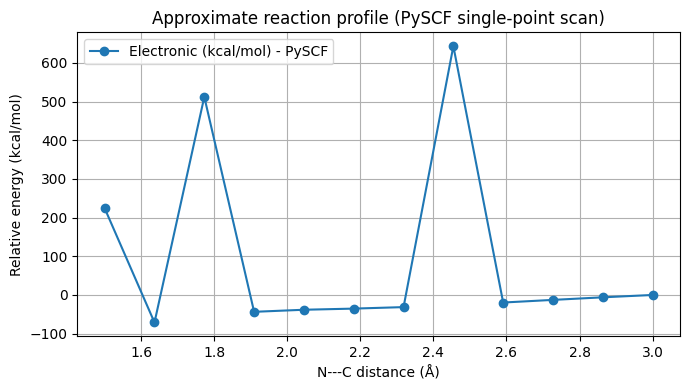

In [21]:
from pyscf.geomopt import berny_solver as geomopt
from pyscf.geomopt.berny_solver import GeometryOptimizer

try:
    from pyscf import gto, dft, scf
    PYSCF_AVAILABLE = True
except Exception:
    PYSCF_AVAILABLE = False
def xyz_to_coords(xyz_string):
    """
    Parse an XYZ string (without the atom count/header line)
    into (coords, symbols).
    coords: np.ndarray of shape (N,3)
    symbols: list of atomic symbols
    """
    lines = [l.strip() for l in xyz_string.strip().splitlines() if l.strip()]
    symbols, coords = [], []
    for line in lines:
        parts = line.split()
        symbols.append(parts[0])
        coords.append([float(x) for x in parts[1:4]])
    return np.array(coords, dtype=float), symbols

if PYSCF_AVAILABLE:
    print('Running PySCF B3LYP/cc-pVTZ single-point scan along N---C approach (this may take several minutes)...')
    co2_coords, co2_syms = xyz_to_coords(CO2_xyz)
    nh3_coords, nh3_syms = xyz_to_coords(NH3_xyz)

    r_values = np.linspace(3.0, 1.5, 12)
    energies = []
    for r in r_values:
        # position NH3 centroid at distance r along x from C atom
        c_pos = co2_coords[0]
        nh3_centroid = nh3_coords.mean(axis=0)
        target_centroid = c_pos + np.array([r, 0.0, 0.0])
        shift = target_centroid - nh3_centroid
        coords_shifted = nh3_coords + shift
        # build atom spec for PySCF
        atom_lines = []
        for s,c in zip(co2_syms, co2_coords):
            atom_lines.append(f"{s} {c[0]:.8f} {c[1]:.8f} {c[2]:.8f}")
        for s,c in zip(nh3_syms, coords_shifted):
            atom_lines.append(f"{s} {c[0]:.8f} {c[1]:.8f} {c[2]:.8f}")
        atom_spec = '; '.join(atom_lines)
        try:
            mol = gto.M(atom=atom_spec, basis='cc-pvtz', unit='Angstrom')
            mf = dft.RKS(mol)
            mf.xc = 'B3LYP'
            e = mf.kernel()
            if mf.converged:
                etot = mf.e_tot
            else:
                etot = mf.e_tot
            energies.append(float(etot))
            print(f'r={r:.3f} Å  E = {etot:.8f} Ha')
        except Exception as exc:
            print('PySCF single-point failed at r=', r, '->', exc)
            energies.append(np.nan)

    # Save energies and plot approximate PES (electronic only)
    if energies:
        plt.figure(figsize=(7,4))
        rel_kcal = [(e-energies[0])*627.509 if not np.isnan(e) else np.nan for e in energies]
        plt.plot(r_values, rel_kcal, '-o', label='Electronic (kcal/mol) - PySCF')
        plt.xlabel('N---C distance (Å)')
        plt.ylabel('Relative energy (kcal/mol)')
        plt.legend()
        plt.grid(True)
        plt.title('Approximate reaction profile (PySCF single-point scan)')
        plt.tight_layout()
        plt.savefig('pyscf_reaction_profile.png', dpi=200)
        plt.show()
else:
    print('PySCF not available in this kernel. To run PySCF single-point scans, install with `pip install pyscf`.')